In [1]:
import os
import tensorflow as tf
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import pandas as pd
from keras.utils import generic_utils

2022-09-30 13:46:31.946000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:46:32.046007: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-30 13:46:32.070558: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 13:46:32.528575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load Model

In [3]:
#load model
from tensorflow.keras.models import load_model

model_dir ='/media/tohn/SSD/ModelEfficientV2/Model_effnetV2M_5ClassOV/efficientnetV2M_5ClassOV.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-09-30 13:46:41.406718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:46:41.806500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9453 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


# DATA

In [4]:
#Train
dataframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_1200imgs_round1_train.csv')
dataframe['class'] = dataframe['class'].astype(str)
print(dataframe.shape)
dataframe.head()

#validation
valframe = pd.read_csv('/media/tohn/HDD/VISION_dataset/DATA_OVRDT/CSV/azure_ovrdtDB_Alllevel_2430imgs_round1.csv') #เปลี่ยนตาม test set 
valframe = valframe[valframe['data'] == 'test']
valframe['class'] = valframe['class'].astype(str)
print(valframe.shape)
valframe.head()

DATA_PATH = "/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

(1200, 10)
(930, 10)
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/train
/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrdtDB_08_06_65_from_AjOP_labeled/ovrdtDB_1/validation


In [5]:
#Setting data loader
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = train_dir,
        x_col = 'path',
        y_col = 'class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 930 validated image filenames belonging to 6 classes.
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}


## Predict Step

In [6]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=valframe['path'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

2022-09-30 13:48:17.208663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-30 13:48:17.558809: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 68ms/step


In [8]:
valframe['category_ov'] = pred_list
valframe['Prob_ov'] = prob_list
valframe

,Unnamed: 0,fileName,class,path,path_filename,ov_level,ov,path_crop,OSofRec,data,category_ov,Prob_ov
129,129,bcqzrjlqzv.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,test,0,0.384830
130,130,erpcbrwiei.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,test,5,0.393757
131,131,dquemcuexa.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,test,1,0.369813
132,132,ezmaihgoza.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,test,1,0.343897
133,133,faiuawowiz.png.jpg,0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,Android,test,3,0.294978
...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2425,08D18B25-0BFF-4259-98B6-7A7F6FF70811.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,0.0,0.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,test,1,0.311568
2426,2426,1B433378-05D6-4427-B54B-9793E06C7266.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,2.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,test,1,0.280144
2427,2427,7A028307-16EF-4A68-9A6F-8F4D37B28F42.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,3.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,test,5,0.392427
2428,2428,8F486CFA-7FE6-45BA-8251-EC5AC38A8C1A.jpg,5,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/ovrd...,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,3.0,1.0,/media/tohn/HDD/VISION_dataset/DATA_OVRDT/imag...,IOS,test,3,0.268533


In [9]:
data_train = valframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category_ov'])
print('Predicted : ',len(pred_class))
print(pred_class)
print('-'*50)
#เช็คคลาสใน Actual
classe = set(data_train['class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  6
{'2', '5', '0', '1', '3', '4'}
--------------------------------------------------
Actual :  6
{'2', '5', '0', '1', '3', '4'}


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = data_train['class'].array
pred = data_train['category_ov'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 26.666666666666668%
              precision    recall  f1-score   support

           0       0.43      0.20      0.28       161
           1       0.20      0.42      0.27       166
           2       0.10      0.01      0.02       206
           3       0.30      0.55      0.39       205
           4       0.37      0.15      0.21       173
           5       0.16      0.26      0.20        19

    accuracy                           0.27       930
   macro avg       0.26      0.27      0.23       930
weighted avg       0.27      0.27      0.23       930



Text(0.5, 21.249999999999993, 'Predicted label')

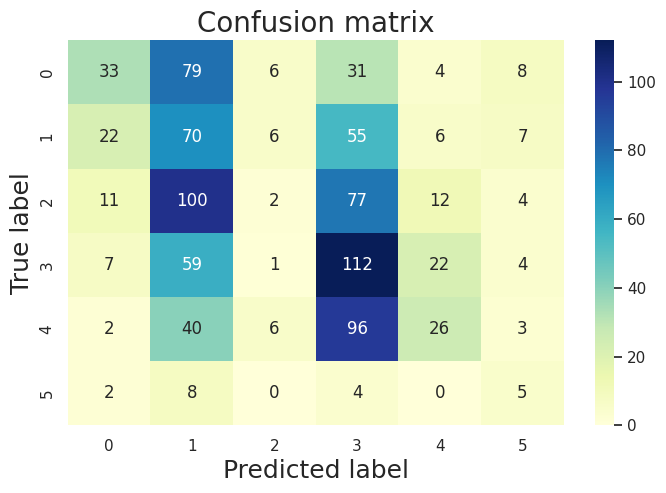

In [11]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)